In [ ]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


In [ ]:
import collections
from d2l import mxnet as d2l
import math
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
import os
import time

npx.set_np()

In [ ]:
#@save 
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [ ]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

    
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [ ]:
transform_train = gluon.data.vision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height to width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new image with a height and width of 224
    # pixels each
    gluon.data.vision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                                   ratio=(3.0/4.0, 4.0/3.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    # Randomly change the brightness, contrast, and saturation
    gluon.data.vision.transforms.RandomColorJitter(brightness=0.4,
                                                   contrast=0.4,
                                                   saturation=0.4),
    # Add random noise
    gluon.data.vision.transforms.RandomLighting(0.1),
    gluon.data.vision.transforms.ToTensor(),
    # Standardize each channel of the image
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

In [ ]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    # Crop a square of 224 by 224 from the center of the image
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

In [ ]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ('train', 'valid', 'train_valid', 'test')]

In [ ]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True, 
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='keep')

In [ ]:
def get_net(devices):
    finetune_net = gluon.model_zoo.vision.resnet34_v2(pretrained=True)
    # Define a new output network
    finetune_net.output_new = nn.HybridSequential(prefix='')
    finetune_net.output_new.add(nn.Dense(256, activation='relu'))
    # There are 120 output categories
    finetune_net.output_new.add(nn.Dense(120))
    # Initialize the output network
    finetune_net.output_new.initialize(init.Xavier(), ctx=devices)
    # Distribute the model parameters to the CPUs or GPUs used for computation
    finetune_net.collect_params().reset_ctx(devices)
    return finetune_net

In [ ]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        X_shards, y_shards = d2l.split_batch(features, labels, devices)
        output_features = [net.features(X_shard) for X_shard in X_shards]
        outputs = [net.output_new(feature) for feature in output_features]
        ls = [loss(output, y_shard).sum() for output, y_shard
              in zip(outputs, y_shards)]
        l_sum += sum([float(l.sum()) for l in ls])
        n += labels.size
    return l_sum / n

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    trainer = gluon.Trainer(net.output_new.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            X_shards, y_shards = d2l.split_batch(features, labels, devices)
            output_features = [net.features(X_shard) for X_shard in X_shards]
            with autograd.record():
                outputs = [net.output_new(feature)
                           for feature in output_features]
                ls = [loss(output, y_shard).sum() for output, y_shard
                      in zip(outputs, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            metric.add(sum([float(l.sum()) for l in ls]), labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 2.319, valid loss 2.609
225.6 examples/sec on [gpu(0), gpu(1)]


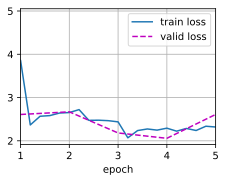

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.01, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 2.279
231.3 examples/sec on [gpu(0), gpu(1)]


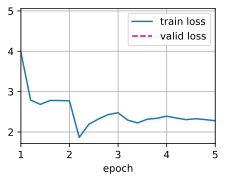

In [ ]:
net = get_net(devices)
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output_features = net.features(data.as_in_ctx(devices[0]))
    output = npx.softmax(net.output_new(output_features))
    preds.extend(output.asnumpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.synsets) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')